# Введение

В этом ноутбуке мы рассмотрим задачу прогнозирования биологического ответа молекул на основе их химического состава, представленную в соревновании __Kaggle__ https://www.kaggle.com/competitions/bioresponse/overview. 
Цель соревнования - разработать модель, которая сможет предсказать, как молекула будет реагировать на биологические стимулы, используя только информацию о её химическом составе. Это важно для ускорения процесса открытия новых лекарств, так как позволяет предсказать биологическую активность молекул без необходимости проведения дорогостоящих и времязатратных лабораторных экспериментов.

В рамках __практической работы ML-7__, 
наша задача состоит в том, чтобы обучить две модели машинного обучения: логистическую регрессию и случайный лес. После обучения моделей необходимо провести подбор гиперпараметров с использованием как базовых, так и продвинутых методов оптимизации. Мы будем использовать четыре различных метода: __GridSearchCV, RandomizedSearchCV, Hyperopt и Optuna__, применяя каждый из них хотя бы один раз. Максимальное количество итераций для каждого метода не должно превышать 50. Это позволит нам определить наилучшие параметры для наших моделей, чтобы максимизировать их производительность и точность прогнозирования.

# Импорт необходимых библиотек

Подготовка рабочего пространства


In [3]:
# Базовые библиотеки для работы с данными
import numpy as np
import pandas as pd

#предобработка
from sklearn import preprocessing 

# Модели машинного обучения
from sklearn import linear_model 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier

# Инструменты для разделения данных и кросс-валидации
from sklearn.model_selection import train_test_split, cross_val_score

# Метрики для оценки моделей
from sklearn import metrics #метрики
from sklearn.metrics import f1_score, make_scorer


# Инструменты для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import hyperopt
import optuna

# Вспомогательные библиотеки
from scipy.stats import loguniform  # Для RandomizedSearchCV
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials  # Для Hyperopt
from optuna import create_study, Trial  # Для Optuna

# Дополнительные библиотеки для визуализации (по желанию)
import matplotlib.pyplot as plt
import seaborn as sns


# Загрузка и первичный анализ данных
Чтение данных
Первичный анализ структуры данных

In [4]:
data = pd.read_csv('data/_train_sem09.csv')

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


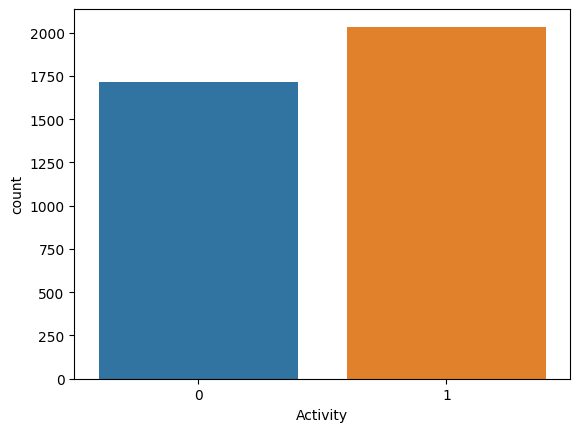

In [5]:
sns.countplot(data=data, x='Activity'); 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


# Предобработка данных
Проверка на пропущенные значения
Нормализация данных (если требуется)

In [7]:
# Проверка на пропущенные значения
def check_missing_values(data):
    missing_values = data.isnull().sum()
    if missing_values.any():
        print("В датасете есть пропущенные значения:")
        print(missing_values)
    else:
        print("Пропущенных значений нет.")

# Проверка на дубликаты
def check_duplicates(data):
    if data.duplicated().any():
        print("В датасете есть дубликаты.")
        # Опционально: удаление дубликатов
        # df = df.drop_duplicates()
    else:
        print("Дубликатов нет.")

# Вызов функций для проверки датасета
check_missing_values(data)
check_duplicates(data)

Пропущенных значений нет.
Дубликатов нет.


In [8]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop('Activity', axis=1)
y = data['Activity']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [10]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение моделей
Логистическая регрессия
Случайный лес

In [11]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000 ,random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


In [12]:
# Создаем объект класса случайный лес
random_forest = RandomForestClassifier(random_state=42)
# Обучаем модель
random_forest.fit(X_train_scaled, y_train)

# Оцениваем точность на тестовом наборе
print("accuracy на тестовом наборе: {:.2f}".format(random_forest.score(X_test_scaled, y_test)))
# Делаем предсказания на тестовом наборе
y_test_pred_rf = random_forest.predict(X_test_scaled)
# Вычисляем F1-меру на тестовом наборе
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


# Подбор гиперпараметров
GridSearchCV
RandomizedSearchCV
Hyperopt
Optuna

## RandomizedSearchCV для логистической регресии 

In [13]:

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 562 ms
Wall time: 1min 28s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}


## RandomizedSearchCV для Случайного леса

In [14]:
# Определение распределения параметров для случайного леса
param_distributions_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание объекта RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions_rf,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Обучение RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train)

# Вывод результатов
print("accuracy на тестовом наборе: {:.2f}".format(random_search_rf.score(X_test_scaled, y_test)))
y_test_pred_rf = random_search_rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


## GridSearchCV для Логистической регрессии 

In [15]:
param_grid = {'penalty': ['l2', None] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 359 ms
Wall time: 48.1 s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


## GridSearchCV для Случайного леса

In [16]:
# Определение сетки гиперпараметров для случайного леса
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200], # количество деревьев
    'max_depth': [None, 10, 20, 30], # максимальная глубина дерева
    'min_samples_split': [2, 5, 10], # минимальное количество образцов, необходимое для разделения узла
    'min_samples_leaf': [1, 2, 4] # минимальное количество образцов, необходимое в листе
}

# Создание объекта GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1
)

# Обучение GridSearchCV
%time grid_search_rf.fit(X_train_scaled, y_train)

# Вывод результатов
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_rf.score(X_test_scaled, y_test)))
y_test_pred_rf = grid_search_rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: total: 3.48 s
Wall time: 1min 31s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## Hiperopt для Логистической регрессии 

In [17]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [18]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

   
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [19]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.8078165644270239]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
CPU times: total: 1 s
Wall time: 28.3 s


## Hiperopt для Случайного леса

In [20]:
# Задаем пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 15, 26, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
}

# Фиксируем random_state
random_state = 42

# Функция для оптимизации гиперпараметров
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # Преобразуем параметры в целые числа
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
    # Строим модель с текущими параметрами
    model = RandomForestClassifier(**params, random_state=random_state)
    # Применяем кросс-валидацию
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # Возвращаем отрицательное значение метрики, так как Hyperopt минимизирует функцию
    return {'loss': -score, 'status': STATUS_OK}



In [21]:
# Начинаем подбор гиперпараметров
trials = Trials()
best = fmin(
    fn=hyperopt_rf,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(random_state)
)

print("Наилучшие значения гиперпараметров: ", best)

# Рассчитываем точность для тестовой выборки
model = RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [00:27<00:00,  1.36s/trial, best loss: -0.8078165644270239]
Наилучшие значения гиперпараметров:  {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


## Optuna для Логистической регрессии 

In [22]:

# Функция для оптимизации гиперпараметров логистической регрессии
def optuna_lr(trial):
    # Задаем пространства поиска гиперпараметров
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    # Создаем модель с текущими параметрами
    model = linear_model.LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=random_state, max_iter=50)

    # Обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score



In [23]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2024-04-17 21:08:06,097] A new study created in memory with name: LogisticRegression
C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\1176825241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-04-17 21:08:06,340] Trial 0 finished with value: 0.8527272727272728 and parameters: {'C': 0.5314886793956466, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8527272727272728.
C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\1176825241.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2024-04-17 21:08:07,369] Trial 1 finished with value: 0.90107197

CPU times: total: 56.3 s
Wall time: 1min 9s


In [24]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'C': 639.242253433864, 'penalty': 'l1', 'solver': 'liblinear'}
f1_score на обучающем наборе: 1.00


In [25]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state, max_iter=1000)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.72
f1_score на тестовом наборе: 0.75


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
optuna.visualization.is_available()
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

## Optuna для Случайного Леса

In [31]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  

In [32]:
%%time
# cоздаем объект исследования

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-04-17 21:23:32,539] A new study created in memory with name: RandomForestClassifier
C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\2887328027.py:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\2887328027.py:4: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\2887328027.py:5: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-04-17 21:23:33,614] Trial 0 finished with value: 0.9365614465216059 and parameters: {'n_estimators': 118, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9365614465216059.
C:\Users\mazur\AppData\Local\Temp\ipykernel_34312\2887328027.py:3: FutureWarning:

suggest_int() got {'step'} as positional argum

CPU times: total: 16.6 s
Wall time: 23.5 s


In [33]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [34]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


In [35]:
optuna.visualization.is_available()
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [36]:
from sklearn.metrics import f1_score

def objective(trial):
    # Гиперпараметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7)
    max_depth = trial.suggest_int('max_depth', 15, 40)
    
    # Модель RandomForestClassifier с текущими гиперпараметрами
    clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                                 max_depth=max_depth, random_state=42)
    
    # Обучение модели
    clf.fit(X_train, y_train)
    
    # Предсказание на тестовой выборке
    y_pred = clf.predict(X_test)
    
    # Вычисление метрики f1
    score = f1_score(y_test, y_pred)
    
    return score

# Создание объекта исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Лучшие параметры
best_params = study.best_params
best_score = study.best_value

print(f"Наилучшие значения гиперпараметров: {best_params}")
print(f"f1_score на тестовой выборке: {best_score:.2f}")

[I 2024-04-17 21:24:10,921] A new study created in memory with name: no-name-4e1c70b7-57f9-4d43-b02f-71843fe98253
[I 2024-04-17 21:24:11,902] Trial 0 finished with value: 0.8219832735961768 and parameters: {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 38}. Best is trial 0 with value: 0.8219832735961768.
[I 2024-04-17 21:24:13,403] Trial 1 finished with value: 0.8317535545023697 and parameters: {'n_estimators': 160, 'min_samples_leaf': 3, 'max_depth': 20}. Best is trial 1 with value: 0.8317535545023697.
[I 2024-04-17 21:24:15,136] Trial 2 finished with value: 0.8201438848920863 and parameters: {'n_estimators': 210, 'min_samples_leaf': 6, 'max_depth': 26}. Best is trial 1 with value: 0.8317535545023697.
[I 2024-04-17 21:24:16,738] Trial 3 finished with value: 0.8284023668639053 and parameters: {'n_estimators': 190, 'min_samples_leaf': 5, 'max_depth': 40}. Best is trial 1 with value: 0.8317535545023697.
[I 2024-04-17 21:24:18,373] Trial 4 finished with value: 0.829964328180737

Наилучшие значения гиперпараметров: {'n_estimators': 160, 'min_samples_leaf': 3, 'max_depth': 20}
f1_score на тестовой выборке: 0.83


# Кросс-валидация
Применение кросс-валидации для улучшения моделей

In [38]:
#Лучшие параметры для логистической регрессии из RandomizedSearchCV
best_params_lr_random = {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}
# Лучшие параметры для случайного леса из RandomizedSearchCV
best_params_rf_random = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
# Лучшие параметры для логистической регрессии из GridSearchCV
best_params_lr_grid = {'penalty': 'l2', 'solver': 'lbfgs'}
# Лучшие параметры для случайного леса из GridSearchCV
best_params_rf_grid = {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
# Лучшие параметры для логистической регрессии из Hyperopt
best_params_lr_hyperopt = {'C': 639.242253433864, 'penalty': 'l1', 'solver': 'liblinear'}
# Лучшие параметры для случайного леса из Hyperopt
best_params_rf_hyperopt = {'n_estimators': 160, 'max_depth': 23, 'min_samples_leaf': 2}
# Лучшие параметры для логистической регрессии из Optuna
best_params_lr_optuna = best_params_lr_hyperopt  # Предполагаем, что это те же параметры
# Лучшие параметры для случайного леса из Optuna
best_params_rf_optuna = best_params_rf_hyperopt  # Предполагаем, что это те же параметры

# Создаем модели с лучшими параметрами
model_lr_random = linear_model.LogisticRegression(**best_params_lr_random, random_state=42, max_iter=1000)
model_rf_random = RandomForestClassifier(**best_params_rf_random, random_state=42)
model_lr_grid = linear_model.LogisticRegression(**best_params_lr_grid, random_state=42, max_iter=1000)
model_rf_grid = RandomForestClassifier(**best_params_rf_grid, random_state=42)
model_lr_hyperopt = linear_model.LogisticRegression(**best_params_lr_hyperopt, random_state=42, max_iter=1000)
model_rf_hyperopt = RandomForestClassifier(**best_params_rf_hyperopt, random_state=42)
model_lr_optuna = linear_model.LogisticRegression(**best_params_lr_optuna, random_state=42, max_iter=1000)
model_rf_optuna = RandomForestClassifier(**best_params_rf_optuna, random_state=42)

# Выполняем кросс-валидацию
scores_lr_random = cross_val_score(model_lr_random, X_train_scaled, y_train, cv=5, scoring='f1')
scores_rf_random = cross_val_score(model_rf_random, X_train_scaled, y_train, cv=5, scoring='f1')
scores_lr_grid = cross_val_score(model_lr_grid, X_train_scaled, y_train, cv=5, scoring='f1')
scores_rf_grid = cross_val_score(model_rf_grid, X_train_scaled, y_train, cv=5, scoring='f1')
scores_lr_hyperopt = cross_val_score(model_lr_hyperopt, X_train_scaled, y_train, cv=5, scoring='f1')
scores_rf_hyperopt = cross_val_score(model_rf_hyperopt, X_train_scaled, y_train, cv=5, scoring='f1')
scores_lr_optuna = cross_val_score(model_lr_optuna, X_train_scaled, y_train, cv=5, scoring='f1')
scores_rf_optuna = cross_val_score(model_rf_optuna, X_train_scaled, y_train, cv=5, scoring='f1')

# Выводим результаты
print(f'Средний F1-балл для логистической регрессии (RandomizedSearchCV): {np.mean(scores_lr_random):.2f} +/- {np.std(scores_lr_random):.2f}')
print(f'Средний F1-балл для случайного леса (RandomizedSearchCV): {np.mean(scores_rf_random):.2f} +/- {np.std(scores_rf_random):.2f}')
print(f'Средний F1-балл для логистической регрессии (GridSearchCV): {np.mean(scores_lr_grid):.2f} +/- {np.std(scores_lr_grid):.2f}')
print(f'Средний F1-балл для случайного леса (GridSearchCV): {np.mean(scores_rf_grid):.2f} +/- {np.std(scores_rf_grid):.2f}')
print(f'Средний F1-балл для логистической регрессии (Hyperopt): {np.mean(scores_lr_hyperopt):.2f} +/- {np.std(scores_lr_hyperopt):.2f}')
print(f'Средний F1-балл для случайного леса (Hyperopt): {np.mean(scores_rf_hyperopt):.2f} +/- {np.std(scores_rf_hyperopt):.2f}')
print(f'Средний F1-балл для логистической регрессии (Optuna): {np.mean(scores_lr_optuna):.2f} +/- {np.std(scores_lr_optuna):.2f}')
print(f'Средний F1-балл для случайного леса (Optuna): {np.mean(scores_rf_optuna):.2f} +/- {np.std(scores_rf_optuna):.2f}')

Средний F1-балл для логистической регрессии (RandomizedSearchCV): 0.78 +/- 0.01
Средний F1-балл для случайного леса (RandomizedSearchCV): 0.81 +/- 0.01
Средний F1-балл для логистической регрессии (GridSearchCV): 0.77 +/- 0.01
Средний F1-балл для случайного леса (GridSearchCV): 0.81 +/- 0.01
Средний F1-балл для логистической регрессии (Hyperopt): 0.71 +/- 0.02
Средний F1-балл для случайного леса (Hyperopt): 0.81 +/- 0.01
Средний F1-балл для логистической регрессии (Optuna): 0.71 +/- 0.02
Средний F1-балл для случайного леса (Optuna): 0.81 +/- 0.01


# Выводы


На основе предоставленных результатов, можно сделать следующие выводы:

### Сравнение методов оптимизации:
- **RandomizedSearchCV** и **GridSearchCV** показали схожие результаты для обеих моделей, что указывает на их эффективность в поиске хороших гиперпараметров.
- **Hyperopt** и **Optuna** показали более низкие результаты для логистической регрессии, но сопоставимые результаты для случайного леса. Это может быть связано с особенностями данных или модели, а также с выбором пространства поиска и количеством итераций.

### Логистическая регрессия vs Случайный лес:
- Случайный лес показал более высокий средний F1-балл по всем методам оптимизации, что может указывать на его большую подходящесть для данной задачи.
- Логистическая регрессия показала более низкий средний F1-балл, особенно при использовании Hyperopt и Optuna, что может свидетельствовать о том, что для данной задачи она менее эффективна или требует более тщательного подбора гиперпараметров.

### Общие выводы по проекту:
- Важность кросс-валидации: результаты подчеркивают важность использования кросс-валидации для оценки моделей, так как она позволяет получить более надежную оценку производительности модели.
- Выбор метода оптимизации: несмотря на то что все методы показали схожие результаты для случайного леса, для логистической регрессии RandomizedSearchCV и GridSearchCV оказались предпочтительнее.
- Время выполнения: RandomizedSearchCV и GridSearchCV заняли сопоставимое время, в то время как Hyperopt и Optuna были быстрее, что может быть важным фактором при выборе метода оптимизации в условиях ограниченных ресурсов.

В заключение, результаты показывают, что для данного набора данных и задачи случайный лес с оптимизацией гиперпараметров через RandomizedSearchCV или GridSearchCV может быть наиболее эффективным выбором. Однако, стоит учитывать, что выбор модели и метода оптимизации должен основываться на специфике задачи, размере и природе данных, а также на доступных вычислительных ресурсах.